In [1]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade mxnet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade gluoncv

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install "opencv-python-headless<4.3"

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import cv2
import mxnet as mx
from mxnet.gluon.data.vision import transforms
import gluoncv
import imageio as iio
# using cpu
ctx = mx.cpu(0)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.7.1+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
# Docker Pytorch Part
# Predict depth and split the image into 4 parts 


#### Part 1A: Import the panorama image

In [10]:

filename = '../Project-demo/sample_data/test_img_4.jpg'


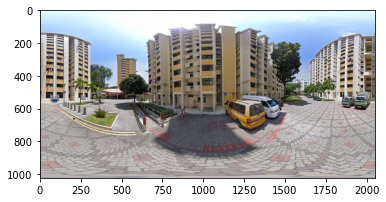

In [11]:
import PIL.Image as pil

img = pil.open(filename).convert('RGB')

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

#### Part 1A: resize and predict depth

In [12]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

/tmp/ipykernel_175/3791877393.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


In [13]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

In [14]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [15]:
import matplotlib as mpl
import matplotlib.cm as cm

In [16]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
# here the original depth is presented in mm 
# so 1000 should be a proper way to do
disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)

In [20]:
disp_resized_np

array([[21, 21, 22, ..., 23, 23, 23],
       [22, 22, 22, ..., 23, 23, 23],
       [22, 22, 22, ..., 23, 23, 23],
       ...,
       [ 5,  4,  3, ...,  2,  3,  3],
       [ 5,  4,  3, ...,  2,  3,  3],
       [ 5,  4,  3, ...,  2,  3,  3]], dtype=uint8)

#### Part 1A: Convert array to image and visualize

In [22]:
iio.imwrite('../Project-demo/sample_data/depth_predict_4.png', disp_resized_np)

In [23]:
 # Read depth and color image:
    
depth_image = iio.imread('../Project-demo/sample_data/depth_predict_4.png')
rgb_image = iio.imread('../Project-demo/sample_data/test_img_4.jpg')

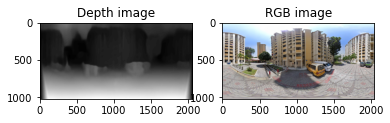

In [24]:
    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    
    axs[0].set_title('Depth image')
    
    axs[1].imshow(rgb_image)
    axs[1].set_title('RGB image')
    plt.show()


#### Part 1B: Define the Spilt Function

In [25]:
import os
import sys
import cv2
import numpy as np

def xyz2lonlat(xyz):
    atan2 = np.arctan2
    asin = np.arcsin

    norm = np.linalg.norm(xyz, axis=-1, keepdims=True)
    xyz_norm = xyz / norm
    x = xyz_norm[..., 0:1]
    y = xyz_norm[..., 1:2]
    z = xyz_norm[..., 2:]

    lon = atan2(x, z)
    lat = asin(y)
    lst = [lon, lat]

    out = np.concatenate(lst, axis=-1)
    return out

def lonlat2XY(lonlat, shape):
    X = (lonlat[..., 0:1] / (2 * np.pi) + 0.5) * (shape[1] - 1)
    Y = (lonlat[..., 1:] / (np.pi) + 0.5) * (shape[0] - 1)
    lst = [X, Y]
    out = np.concatenate(lst, axis=-1)

    return out 

class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    

    def GetPerspective(self, FOV, THETA, PHI, height, width):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        f = 0.5 * width * 1 / np.tan(0.5 * FOV / 180.0 * np.pi)
        cx = (width - 1) / 2.0
        cy = (height - 1) / 2.0
        K = np.array([
                [f, 0, cx],
                [0, f, cy],
                [0, 0,  1],
            ], np.float32)
        K_inv = np.linalg.inv(K)
        
        x = np.arange(width)
        y = np.arange(height)
        x, y = np.meshgrid(x, y)
        z = np.ones_like(x)
        xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
        xyz = xyz @ K_inv.T

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        x_axis = np.array([1.0, 0.0, 0.0], np.float32)
        R1, _ = cv2.Rodrigues(y_axis * np.radians(THETA))
        R2, _ = cv2.Rodrigues(np.dot(R1, x_axis) * np.radians(PHI))
        R = R2 @ R1
        xyz = xyz @ R.T
        lonlat = xyz2lonlat(xyz) 
        XY = lonlat2XY(lonlat, shape=self._img.shape).astype(np.float32)
        persp = cv2.remap(self._img, XY[..., 0], XY[..., 1], cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

        return persp

#### Part 1B: Spilt rgb to 4 parts and predict depth

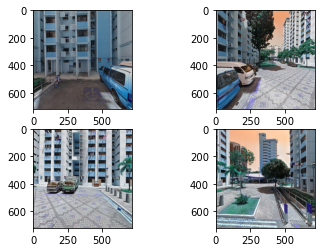

In [41]:
import os
import cv2 
from PIL import Image
import numpy as np
#import Equirec2Perspec as E2P 

equ = Equirectangular("../Project-demo/sample_data/test_img_4.jpg")    # Load equirectangular image
    #
    # FOV unit is degree 
    # theta is z-axis angle(right direction is positive, left direction is negative)
    # phi is y-axis angle(up direction positive, down direction negative)
    # height and width is output image dimension 
    #
img_0 = equ.GetPerspective(90, 0, 0, 720, 720) # Specify parameters(FOV, theta, phi, height, width)
img_0 = Image.fromarray(img_0, 'RGB')

img_90 = equ.GetPerspective(90, 90, 0, 720, 720) # Specify parameters(FOV, theta, phi, height, width)
img_90 = Image.fromarray(img_90, 'RGB')

img_180 = equ.GetPerspective(90, 180, 0, 720, 720) # Specify parameters(FOV, theta, phi, height, width)
img_180 = Image.fromarray(img_180, 'RGB')

img_270 = equ.GetPerspective(90, 270, 0, 720, 720) # Specify parameters(FOV, theta, phi, height, width)
img_270 = Image.fromarray(img_270, 'RGB')



fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(img_0)
axs[0,1].imshow(img_90)
axs[1,0].imshow(img_180)
axs[1,1].imshow(img_270)


plt.show()

#### Part 1B: resize and predict depth

In [42]:
i = 0
for img in  [img_0,img_90,img_180,img_270]:
    

    img.save('../Project-demo/sample_data/test_img_4_spilt_{}.png'.format(str(i)))
    

    original_width, original_height = img.size
    feed_height = 192
    feed_width = 640

    img = img.resize((feed_width, feed_height), pil.LANCZOS)
    img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

    outputs = model.predict(img)
    disp = outputs[("disp", 0)]
    disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)
    
    disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
    # here the original depth is presented in mm 
    # so 1000 should be a proper way to do
    disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)
    
    iio.imwrite('../Project-demo/sample_data/depth_predict_4_spilt_{}.png'.format(str(i)), disp_resized_np)
    
    
    
    i += 1
    

/tmp/ipykernel_175/1100491587.py:12: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


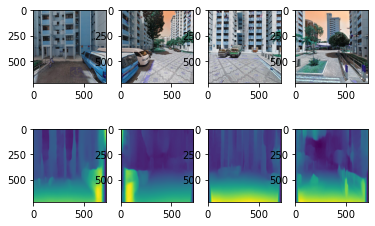

In [45]:
fig, axs = plt.subplots(2, 4)
for i in range(4):
    
    depth_file = '../Project-demo/sample_data/depth_predict_4_spilt_{}.png'.format(str(i))
    rgb_file = '../Project-demo/sample_data/test_img_4_spilt_{}.png'.format(str(i))
    depth_image = iio.imread(depth_file)
    rgb_image = iio.imread( rgb_file)
    
    axs[0,i].imshow(rgb_image)
    axs[1,i].imshow(depth_image)
plt.show()